# Sobre árboles de decisión

Comenzaremos revisando algunos conceptos básicos sobre el funcionamiento de los árboles de decisión. A medida que avancemos en las clases, exploraremos sus diversas características y desafíos, con el objetivo de comprender por qué, en problemas de modelado de datos tabulares, siguen siendo el estado del arte, superando incluso a los modelos más complejos de redes neuronales.

Empezaremos con un hermosa visualización de como funcionan gracias a la gente de **R2D3**

[Cómo funciona un árbol de decisión](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

Y luego empezaremos a trabajar con nuestro conjunto de datos para *tratar* de modelar uno. Para eso, debemos iniciar el entorno

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree

Variables importantes

In [2]:
dataset_path = 'C:/Users/c678456/Desktop/Ian/Maestría/Especialización/2do cuatrimestre/DMEyF/datasets/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

Cargamos el **dataset**, vamos a trabajar en esta ocasión solo con un periodo: **202104**.

Algo que va a generar algo de confusión es que no separemos con **Train / Test** en esta ocasión.

**NO ENTRE EN PÁNICO**, en esta cursada se le dedicará mucho tiempo a entender y combatir el problema del overfitting. Pero no hoy.

In [3]:
data = pd.read_csv(dataset_path+dataset_file)
data = data[data['foto_mes'] == 202104]

X = data.drop('clase_ternaria', axis=1)
y = data['clase_ternaria']


Veamos que porcentaje ocupa de nuestro dataset, el target que queremos predecir

In [ ]:
data['clase_ternaria'].value_counts(normalize=True)*100

* **¿Había trabajado con un target tan poco representativo?**
* **¿Cree que esto es algo común o tan solo una rareza?**

In [ ]:
data['clase_ternaria'].value_counts()

## Primer árbol
Con nuestros datos ya cargados en **memoria**, podemos dedicarnos a generar nuestro primer árbol

### Párametros

(gentileza de chat-gpt en un 90%)

El **DecisionTreeClassifier** en scikit-learn tiene varios parámetros que controlan cómo se construye el árbol de decisión. A continuación te explico los más importantes:

1. **criterion**: Este parámetro define la función que se usa para medir la calidad de una división (split). Las opciones principales son:

 * **gini** (predeterminado): Utiliza el índice de Gini, que mide la impureza de las particiones. Un valor de Gini más bajo significa que una partición es más pura.
 * **entropy**: Utiliza la entropía de la información, relacionada con el concepto de ganancia de información. Se enfoca en reducir la incertidumbre en las particiones.

 [Explicación de ambos criterios](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/)

2. **max_depth**: Controla la profundidad máxima del árbol.

3. **min_samples_split**: Especifica el número mínimo de muestras que un nodo debe tener para poder dividirse.

4. **min_samples_leaf**: Define el número mínimo de muestras que debe tener una hoja (nodo final).

5. **max_features**: Indica el número máximo de características que el modelo debe considerar para hacer la mejor división.

6. **max_leaf_nodes**: Especifica el número máximo de nodos hoja que el árbol puede tener.

7. **random_state**: Fija la semilla utilizada por el generador de números aleatorios, lo que garantiza que los resultados del entrenamiento sean reproducibles.

8. **ccp_alpha**: Parámetro de complejidad de poda mínima, utilizado para la poda de árboles de decisión después de que se hayan construido. Un valor más alto lleva a árboles más pequeños.

 **EN LA CURSADA CREEMOS QUE LA INTELIGENCIA DEL ALUMNO CORRELACIONA DE FORMA NEGATIVA A VALOR QUE SETEA ESTE PARÁMETRO.**

Queda de tarea para el alumnado jugar con algunas parametrías. Usaremos a continuación una simple

### Modelo

In [4]:
model = DecisionTreeClassifier(criterion='gini',
                               random_state=17,
                               min_samples_split=80,
                               min_samples_leaf=1,
                               max_depth=5)

model.fit(X, y)

DecisionTreeClassifier(max_depth=5, min_samples_split=80, random_state=17)

### Visualización

Todo es mucho más bonito si tiene colores

In [ ]:
plt.figure(figsize=(40,20))
plot_tree(model, feature_names=X.columns, filled=True, class_names=model.classes_, rounded=True, impurity=False) #,  proportion=True)
plt.show()

### Midiendo el modelo

Mirando tan solo la visualización

* **¿Qué tan bien performó el modelo?**
* **¿Qué tan bien detectó los CONTINUA?**
* **¿Qué tan bien detectó los BAJA+2?**

Para meter manos en la masa, vamos a llevar las hojas del modelo a una tabla, para esto haremos uso de una función auxiliar

In [ ]:
def get_leaf_info(tree):
    tree_ = tree.tree_
    class_names = model.classes_
    leaf_info = []
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            class_counts = tree_.value[i][0]
            predicted_class_index = class_counts.argmax()
            predicted_class = class_names[predicted_class_index]
            row = {
                'Node': i,
                'Samples': int(tree_.n_node_samples[i]),
                'Predicted Class': predicted_class
            }
            for j, class_name in enumerate(class_names):
                row[class_name] = int(class_counts[j]*int(tree_.n_node_samples[i]))
            leaf_info.append(row)
            
    return pd.DataFrame(leaf_info)

leaf_df = get_leaf_info(model)
leaf_df

Ahora en el dataset **leaf_ds** tenemos cada nodo terminal (hoja).

Vemos que según el modelo, no deberíamos mandar ningún estímulo, dado que no detectó ningún **BAJA+2**. Sin embargo dudaremos de esto y veremos cuanta plata nos hubiera dejado cada hoja, si enviáramos a los clientes que cayeron en esta.


In [ ]:
leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df.sort_values("ganancia", ascending=False, inplace=True)
leaf_df

Vaya! no son pocos las hojas que hubieran dado ganancia positiva, y todas a su vez estuvieron mal clasificadas por el modelo.

Veamos de calcular la probabilidad de **BAJA+2** por cada hoja

In [ ]:
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)
leaf_df



Finalmente calculemos la ganancia acumulada para cada posible punto de corte:

In [ ]:
leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum()
leaf_df

* **¿Cuál es la ganancia máxima que puede obtener con este modelo?**
* **¿Nota alguna relación con la probabilidad de corte óptima discutida en la clase anterior?**


### Matrices de Confusión

Todos ya sabemos que es son las matrices de confusión y como usando los valores de la misma, podemos  [calcular varios estadísticos](https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion)

Una diferencia a lo trabajado hasta ahora en la maestría, es que por cada modelo no vamos a generar 1 matriz de confusión, sino múltiples, 1 por cada punto de corte.

Para eso tenemos que proceder:
* Agrupar los buenos y los malos, ya que la mayoría de los indicadores son binarios
* Calcular los valores: **TP, TN, FP y FN**

In [ ]:
leaf_df["evento"] = leaf_df["BAJA+2"]
leaf_df["no_evento"] = leaf_df["CONTINUA"] + leaf_df["BAJA+1"]

leaf_df["evento_acum"] = leaf_df["evento"].cumsum()
leaf_df["no_evento_acum"] = leaf_df["no_evento"].cumsum()

total_evento = leaf_df["evento"].sum()
total_noevento = leaf_df["no_evento"].sum()

leaf_df['evento_restantes'] = total_evento - leaf_df["evento_acum"]
leaf_df['noevento_restantes'] = total_noevento - leaf_df["no_evento_acum"]

leaf_df["TP"] = leaf_df["evento_acum"]
leaf_df["TN"] = leaf_df["noevento_restantes"]
leaf_df["FP"] = leaf_df["no_evento_acum"]
leaf_df["FN"] = leaf_df["evento_restantes"]

leaf_df

Nos quedamos con una tabla reducida

In [ ]:
leaf2_df = leaf_df[["prob_baja_2", "TP", "TN", "FP", "FN"]]
leaf2_df.sort_values("prob_baja_2", ascending=False, inplace=True)
leaf2_df

Con esta tabla podemos nos solo calcular los indicadores clásicos, sino que podemos hacer por cada punto de corte, dibujar la curva y establecer cuál es el optimo punto de corte que máximiza el métrica.



#### curva ROC

La curva ROC (Receiver Operating Characteristic) es una herramienta gráfica utilizada en ciencia de datos para evaluar el rendimiento de un modelo de clasificación binaria. Es particularmente útil para entender  el trade-off entre cuánto podemos ganar, en función de cuanto estamos dispuestos a perder.

Se dibuja como **Tasa de Falsos Positivos** contra **Tasa de Verdaderos Positivos**


In [ ]:
leaf2_df['TPR'] = leaf2_df['TP'] / (leaf2_df['TP'] + leaf2_df['FN'])
leaf2_df['FPR'] = leaf2_df['FP'] / (leaf2_df['FP'] + leaf2_df['TN'])

sns.lineplot(x='FPR', y='TPR', data=leaf2_df)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.grid(True)
plt.show()

# Nota: Es probable que los valores de FPR y TPR esten lejos del [0,0] y [1,1]
# si ese es su caso, debe agregarlos a mano a la tabla

* La línea de identidad indica el comportamiento de un clasificador que no tiene ninguna habilidad para distinguir entre las clases positivas y negativas.
* Es una métrica independiente de la distribución de clases: La curva ROC no depende de la distribución de las clases en los datos (balance de clases), lo que la hace útil en situaciones donde las clases están desbalanceadas.
* Es una evaluación global del modelo: La curva ROC proporciona una visión más completa del rendimiento del modelo.

No todo son rosas, si queremos comparar 2 modelos, mirar curvas puede ser complejo. Por esto mismo, se suele calcular la métrica **AUC** (Area Under the Curve) como un estatístico de la calidad del modelo.

In [ ]:
np.trapz(leaf2_df['TPR'], leaf2_df['FPR']) # calcula el área de bajo de la curva

* AUC = 1: El modelo clasifica perfectamente todas las instancias. Más cerca de 1 se encuentra el indicador, mejor.
* AUC = 0.5: El modelo no tiene capacidad discriminativa; su rendimiento es equivalente a realizar una clasificación aleatoria.
* AUC < 0.5: Indica un rendimiento peor que una clasificación aleatoria (dale vuelta a la clase).
* Más de una curva puede tener la misma AUC, se suele elegir a la más empinada

### Tarea
* Cambie los parámetros del modelo y vea los impactos en cada una de las métricas.
 * ¿Cuál fue el modelo que dió más ganancia económica? ¿El peor?
 * ¿Cuál fue el modelo que dió mayor AUC? ¿El peor?
* Calcule, dibuje y encuentre el punto de corte óptimo para:
 * Accuracy
 * Sensibilidad
 * Especificidad
 * F1-Score

In [ ]:
############################################################################################################
############################################################################################################
###################################################### TAREA ###############################################
############################################################################################################
############################################################################################################

In [ ]:
#1. AUMENTO DE MIN_SAMPLES_LEAF.

In [ ]:
#a. Reentreno el modelo.
model = DecisionTreeClassifier(criterion='gini',
                               random_state=17,
                               min_samples_split=80,
                               min_samples_leaf=5,
                               max_depth=5)

model.fit(X, y)

In [ ]:
#b. Calculo las probabilidades y ganancias.
#i. Obtenemos la info de cada hoja.
def get_leaf_info(tree):
    tree_ = tree.tree_
    class_names = model.classes_
    leaf_info = []
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            class_counts = tree_.value[i][0]
            predicted_class_index = class_counts.argmax()
            predicted_class = class_names[predicted_class_index]
            row = {
                'Node': i,
                'Samples': int(tree_.n_node_samples[i]),
                'Predicted Class': predicted_class
            }
            for j, class_name in enumerate(class_names):
                row[class_name] = int(class_counts[j]*int(tree_.n_node_samples[i]))
            leaf_info.append(row)
            
    return pd.DataFrame(leaf_info)

leaf_df = get_leaf_info(model)

#ii. Calculamos la ganancia de cada hoja.
leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df.sort_values("ganancia", ascending=False, inplace=True)

#iii. Calculamos la probabilidad de "BAJA+2" de cada hoja.
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)

#iv. Calculamos la ganancia acumulada.
leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum()

#v. Visualizamos la tabla.
leaf_df

#vi. Conclusiones.
#print(''' HIPÓTESIS: Si pasamos como parámetro que haya más ejemplares en los nodos hojas (de 1 a 5), tiene sentido
#      que haya mas posibilidades que cada nodo final tenga menor cantidad de muestras de "BAJA+2" (mayor impureza),
#      a costa de descender el overfitting (que se aprenda muy bien los datos) y, por ende, debería haber una mejor
#      distribución de las ganancias entre las hojas. En este sentido, si tengo mayor presencia de "BAJA+2" en diferentes hojas,
#      deberia aumentar la ganancia esperada de mayor cantidad de hojas.
#      \nREALIDAD: Efectivamente, las ganancias esperadas positivas se reparten entre mayor cantidad de números de hojas.
#      En tanto, las ganancias acumulados, el punto más alto es de $129.619.000 vs $ 124.509.000 en el caso anterior.
#      \nCONCLUSION: Debería aumentar la cantidad de ejemplares que debe haber en cada hoja final, así aprovecho esa impureza
#      para tener mayor cantidad de nodos que me dejen ganancias donde invertir.
#      ''')

In [ ]:
#c. Construimos una matriz de confusión.
#i. Calculo cada una de los insumos necesarios (TP,TN,FP,FN) en distintos puntos de corte posibles.
leaf_df["evento"] = leaf_df["BAJA+2"]
leaf_df["no_evento"] = leaf_df["CONTINUA"] + leaf_df["BAJA+1"]

leaf_df["evento_acum"] = leaf_df["evento"].cumsum()
leaf_df["no_evento_acum"] = leaf_df["no_evento"].cumsum()

total_evento = leaf_df["evento"].sum()
total_noevento = leaf_df["no_evento"].sum()

leaf_df['evento_restantes'] = total_evento - leaf_df["evento_acum"]
leaf_df['noevento_restantes'] = total_noevento - leaf_df["no_evento_acum"]

leaf_df["TP"] = leaf_df["evento_acum"]
leaf_df["TN"] = leaf_df["noevento_restantes"]
leaf_df["FP"] = leaf_df["no_evento_acum"]
leaf_df["FN"] = leaf_df["evento_restantes"]

#ii. Lo almaceno en una tabla más prolija.
leaf2_df = leaf_df[["prob_baja_2", "TP", "TN", "FP", "FN"]]
leaf2_df.sort_values("prob_baja_2", ascending=False, inplace=True)

#iii. Visualizo la tabla.
leaf2_df

In [ ]:
#d. Calculo la curva ROC.
#i. Curva ROC propiamente dicha.
leaf2_df['TPR'] = leaf2_df['TP'] / (leaf2_df['TP'] + leaf2_df['FN'])
leaf2_df['FPR'] = leaf2_df['FP'] / (leaf2_df['FP'] + leaf2_df['TN'])

sns.lineplot(x='FPR', y='TPR', data=leaf2_df)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.grid(True)
plt.show()

#ii. Área debajo de la curva.
np.trapz(leaf2_df['TPR'], leaf2_df['FPR']) # calcula el área de bajo de la curva

#iii. Conclusión.
print('''Este nuevo modelo da un aumento en el área debajo de la curva, pasando de
      0.8856 a 0.8889''')

In [ ]:
#e. Punto de corte óptimo para...
#i. Accuracy.
leaf2_df["Accuracy"] =  (leaf2_df["TP"] + leaf2_df["TN"]) / (leaf2_df["TP"] + leaf2_df["TN"] + leaf2_df["FP"] + leaf2_df["FN"])
#ii. Sensibilidad.
leaf2_df["Sensibilidad"] = leaf2_df["TP"] / (leaf2_df["TP"] + leaf2_df["FN"])
#iii. Especificidad.
leaf2_df["Especificidad"] = leaf2_df["TN"] / (leaf2_df["TN"] + leaf2_df["FP"])
#iv. F1-Score.
leaf2_df["Precision"] = leaf2_df["TP"] / (leaf2_df["TP"] + leaf2_df["FP"])
leaf2_df["F1-Score"] = 2* ((leaf2_df["Precision"]*leaf2_df["Sensibilidad"])/(leaf2_df["Precision"]+leaf2_df["Sensibilidad"]))

In [ ]:
#f. Grafico.
#i. Me quedo con las columnas de interés.
df_metricas = leaf2_df[["prob_baja_2","Accuracy","Sensibilidad","Especificidad","Precision","F1-Score"]].reset_index(drop=True)
#ii. Grafico una linea por cada métrica.
plt.plot(df_metricas["prob_baja_2"], df_metricas["Accuracy"], label="Accuracy", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["Sensibilidad"], label="Sensibilidad", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["Especificidad"], label="Especificidad", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["F1-Score"], label="F1-Score", marker='o', linestyle='-')
#iii. Le agrego las etiquetas y labels.
plt.xlabel('Probabilidad "BAJA+2"')
plt.ylabel('Valor de la Métrica')
plt.title('Evolución de las Métricas de Rendimiento')
#iv. Le agrego la leyenda.
plt.legend()
#v. Muestro el gráfico.
plt.show()
#vi. Conclusiones.
print('''
      A mayor probabilidad de "BAJA+2", entonces mayor especificidad (TVN) ---> Pocos Falsos Positivos ya que le 
      mandaré el presente a aquellos nodos hojas con alta probabilidad de "BAJA+2" (alfa muy bajo).
      Ahora bien, en cuanto empiezo a aumentar el valor de alfa (y por ende, a mandarle regalos a hojas con "BAJA+2" más bajos),
      desciende la especificidad (tengo más FP), y aumenta la sensibilidad (tengo menos FN).
      El punto de equilibrio, no coincide con el de F-SCORE (óptimo entre 0.15 y 0.20), ni con el de Ganancias (0.25).
      ''')

In [ ]:
#2. DESCENSO min_samples_split.

In [ ]:
#a. Reentreno el modelo.
model = DecisionTreeClassifier(criterion='gini',
                               random_state=17,
                               min_samples_split=20,
                               min_samples_leaf=1,
                               max_depth=5)

model.fit(X, y)

In [ ]:
#b. Calculo las probabilidades y ganancias.
#i. Obtenemos la info de cada hoja.
def get_leaf_info(tree):
    tree_ = tree.tree_
    class_names = model.classes_
    leaf_info = []
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            class_counts = tree_.value[i][0]
            predicted_class_index = class_counts.argmax()
            predicted_class = class_names[predicted_class_index]
            row = {
                'Node': i,
                'Samples': int(tree_.n_node_samples[i]),
                'Predicted Class': predicted_class
            }
            for j, class_name in enumerate(class_names):
                row[class_name] = int(class_counts[j]*int(tree_.n_node_samples[i]))
            leaf_info.append(row)
            
    return pd.DataFrame(leaf_info)

leaf_df = get_leaf_info(model)

#ii. Calculamos la ganancia de cada hoja.
leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df.sort_values("ganancia", ascending=False, inplace=True)

#iii. Calculamos la probabilidad de "BAJA+2" de cada hoja.
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)

#iv. Calculamos la ganancia acumulada.
leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum()

#v. Visualizamos la tabla.
leaf_df

#vi. Conclusiones.
#print(''' HIPÓTESIS: Si pasamos como parámetro que pueda haber menos muestras en cada hoja a particionar (de 80 a 20), tiene sentido
#      que haya mas nodos, y por ende "BAJA+2" esté mayor repartido (mayor impureza),
#      a costa de aumentar el overfitting (que se aprenda muy bien los datos) y, por ende, debería haber una mejor
#      distribución de las ganancias entre las hojas. En este sentido, si tengo mayor presencia de "BAJA+2" en diferentes hojas,
#      deberia aumentar la ganancia esperada de mayor cantidad de hojas.
#      \nREALIDAD: Efectivamente, las ganancias esperadas positivas se reparten entre mayor cantidad de números de hojas.
#      En tanto, las ganancias acumulados, el punto más alto es de $124.985.000 vs $ 124.509.000 en el caso anterior.
#      \nCONCLUSION: Debería aumentar permitir particionar las hojas a pesar que tengan pocos ejemplares. Así aprovecho esa impureza
#      para tener mayor cantidad de nodos que me dejen ganancias donde invertir.
#      ''')

In [ ]:
#c. Construimos una matriz de confusión.
#i. Calculo cada una de los insumos necesarios (TP,TN,FP,FN) en distintos puntos de corte posibles.
leaf_df["evento"] = leaf_df["BAJA+2"]
leaf_df["no_evento"] = leaf_df["CONTINUA"] + leaf_df["BAJA+1"]

leaf_df["evento_acum"] = leaf_df["evento"].cumsum()
leaf_df["no_evento_acum"] = leaf_df["no_evento"].cumsum()

total_evento = leaf_df["evento"].sum()
total_noevento = leaf_df["no_evento"].sum()

leaf_df['evento_restantes'] = total_evento - leaf_df["evento_acum"]
leaf_df['noevento_restantes'] = total_noevento - leaf_df["no_evento_acum"]

leaf_df["TP"] = leaf_df["evento_acum"]
leaf_df["TN"] = leaf_df["noevento_restantes"]
leaf_df["FP"] = leaf_df["no_evento_acum"]
leaf_df["FN"] = leaf_df["evento_restantes"]

#ii. Lo almaceno en una tabla más prolija.
leaf2_df = leaf_df[["prob_baja_2", "TP", "TN", "FP", "FN"]]
leaf2_df.sort_values("prob_baja_2", ascending=False, inplace=True)

#iii. Visualizo la tabla.
leaf2_df

In [ ]:
#d. Calculo la curva ROC.
#i. Curva ROC propiamente dicha.
leaf2_df['TPR'] = leaf2_df['TP'] / (leaf2_df['TP'] + leaf2_df['FN'])
leaf2_df['FPR'] = leaf2_df['FP'] / (leaf2_df['FP'] + leaf2_df['TN'])

sns.lineplot(x='FPR', y='TPR', data=leaf2_df)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.grid(True)
plt.show()

#ii. Área debajo de la curva.
np.trapz(leaf2_df['TPR'], leaf2_df['FPR']) # calcula el área de bajo de la curva

#iii. Conclusión.
print('''Este nuevo modelo da un aumento en el área debajo de la curva, pasando de
      0.8856 a 0.8860''')

In [ ]:
#e. Punto de corte óptimo para...
#i. Accuracy.
leaf2_df["Accuracy"] =  (leaf2_df["TP"] + leaf2_df["TN"]) / (leaf2_df["TP"] + leaf2_df["TN"] + leaf2_df["FP"] + leaf2_df["FN"])
#ii. Sensibilidad.
leaf2_df["Sensibilidad"] = leaf2_df["TP"] / (leaf2_df["TP"] + leaf2_df["FN"])
#iii. Especificidad.
leaf2_df["Especificidad"] = leaf2_df["TN"] / (leaf2_df["TN"] + leaf2_df["FP"])
#iv. F1-Score.
leaf2_df["Precision"] = leaf2_df["TP"] / (leaf2_df["TP"] + leaf2_df["FP"])
leaf2_df["F1-Score"] = 2* ((leaf2_df["Precision"]*leaf2_df["Sensibilidad"])/(leaf2_df["Precision"]+leaf2_df["Sensibilidad"]))

In [ ]:
#f. Grafico.
#i. Me quedo con las columnas de interés.
df_metricas = leaf2_df[["prob_baja_2","Accuracy","Sensibilidad","Especificidad","Precision","F1-Score"]].reset_index(drop=True)
#ii. Grafico una linea por cada métrica.
plt.plot(df_metricas["prob_baja_2"], df_metricas["Accuracy"], label="Accuracy", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["Sensibilidad"], label="Sensibilidad", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["Especificidad"], label="Especificidad", marker='o', linestyle='-')
plt.plot(df_metricas["prob_baja_2"], df_metricas["F1-Score"], label="F1-Score", marker='o', linestyle='-')
#iii. Le agrego las etiquetas y labels.
plt.xlabel('Probabilidad "BAJA+2"')
plt.ylabel('Valor de la Métrica')
plt.title('Evolución de las Métricas de Rendimiento')
#iv. Le agrego la leyenda.
plt.legend()
#v. Muestro el gráfico.
plt.show()
#vi. Conclusiones.
print('''
      A mayor probabilidad de "BAJA+2", entonces mayor especificidad (TVN) ---> Pocos Falsos Positivos ya que le 
      mandaré el presente a aquellos nodos hojas con alta probabilidad de "BAJA+2" (alfa muy bajo).
      Ahora bien, en cuanto empiezo a aumentar el valor de alfa (y por ende, a mandarle regalos a hojas con "BAJA+2" más bajos),
      desciende la especificidad (tengo más FP), y aumenta la sensibilidad (tengo menos FN).
      El punto de equilibrio, no coincide con el de F-SCORE (óptimo cercano a 0.20), ni con el de Ganancias (0.25).
      ''')

## Explorando el dataset

En esta última parte, vamos a realizar un **EDA** rápido del dataset.



### Sumarizando

Empezamos por un pantallazo sobre todas las variables, con una **sumarización**, agregando 2 estadísticos muy importantes que no trae por defecto **Pandas**

* **Número de valores únicos de una variables**: Muchas veces variables categóricas están codificadas en variables numéricas. Este indicador nos ayudará a detectarlas
* **Número de missing values**: Que cantidad de registros tienen valores numéricos y cuales tiene faltantes. El tratamiento (o no) de missings es uno de los temas que navegarán en los **experimentos colectivos**

Navegue la tabla a la par de el **diccionario de datos**. Los alumnos tienen a subestimar el poder de entender el conjunto de datos a la hora de hacer un buen modelo.

In [5]:
desc_stats = data.describe(include='all') # Calcula estadísticas descriptivas básicas.
missing_values = data.isnull().sum() # Calcula el número de valores faltantes por columna.
unique_values = data.nunique() # Calcula el número de valores distintos por columna.

# Combina las estadísticas en un solo DataFrame
summary_table = pd.DataFrame({
    'Missing Values': missing_values,
    'Unique Values': unique_values
})

pd.concat([summary_table.transpose(), desc_stats], axis=0).transpose()


,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
numero_de_cliente,0.0,164090.0,164090.0,NaN,NaN,NaN,772271665.816485,323157262.21819,249221109.0,519853314.5,733829139.5,999467487.0,1592802567.0
foto_mes,0.0,1.0,164090.0,NaN,NaN,NaN,202104.0,0.0,202104.0,202104.0,202104.0,202104.0,202104.0
active_quarter,0.0,2.0,164090.0,NaN,NaN,NaN,0.987464,0.11126,0.0,1.0,1.0,1.0,1.0
cliente_vip,0.0,2.0,164090.0,NaN,NaN,NaN,0.002718,0.052064,0.0,0.0,0.0,0.0,1.0
internet,0.0,5.0,164090.0,NaN,NaN,NaN,0.062557,0.314061,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Visa_mconsumototal,22277.0,115543.0,141813.0,NaN,NaN,NaN,21777.02085,40410.068243,-52546.65,2266.75,9798.02,26429.29,4323421.99
Visa_cconsumos,22277.0,126.0,141813.0,NaN,NaN,NaN,8.125144,9.755993,0.0,2.0,5.0,11.0,149.0
Visa_cadelantosefectivo,22277.0,13.0,141813.0,NaN,NaN,NaN,0.009146,0.222889,0.0,0.0,0.0,0.0,30.0
Visa_mpagominimo,8198.0,5710.0,155892.0,NaN,NaN,NaN,6105.316428,21275.504736,0.0,586.5,2240.43,5571.75,3216600.6


### Explorando las variables más importantes del modelo

Vamos a profundizar sobre las variables utilizadas por el modelo. Si las eligió el modelo, seguro nos ayudará a entender un poco más los datos, no?

Para este fin, vamos a obtener la importancia de variable del modelo

In [6]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

,feature,importance
107,ctrx_quarter,0.330233
33,mprestamos_personales,0.164212
111,Master_status,0.151954
22,mcuentas_saldo,0.151346
16,mcuenta_corriente,0.062440
...,...,...
58,mttarjeta_visa_debitos_automaticos,0.000000
59,ctarjeta_master_debitos_automaticos,0.000000
60,mttarjeta_master_debitos_automaticos,0.000000
61,cpagodeservicios,0.000000


In [7]:
feature_importances.sort_values('importance', ascending=False).head(10)

,feature,importance
107,ctrx_quarter,0.330233
33,mprestamos_personales,0.164212
111,Master_status,0.151954
22,mcuentas_saldo,0.151346
16,mcuenta_corriente,0.062440
133,Visa_status,0.046475
18,mcaja_ahorro,0.026349
127,Master_fechaalta,0.012571
52,mpayroll,0.010046
51,cpayroll_trx,0.009026


Tomaremos algunas para hacer un doble click

#### ctrx_quarter

**¿Qué significa esta variable?**

Cómo se trata de una variable numéricas, vamos a graficar la densidad por cada clase:

In [ ]:
#. Significado de la variable.
print('''Se trata de una variable que mide ---> Cantidad de movimientos voluntarios en las cuentas bancarias 
      \n(no tarjeta de credito) que el cliente realizó en los ultimos 90 dias.''')

In [ ]:
# Grafico.
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "ctrx_quarter", stat='density')

In [ ]:
print('''Se puede ver como la cantidad de movimientos bancarios de los clientes en los últimos 90 días
      nos permite separar claramente los "CONTINUA" respecto a los que se dan de BAJA.
      Donde, los que se dan de baja suelen hacer pocos movimientos (especialmente los de BAJA+2). Aunque
      hay algunos casos de BAJA+1 que hicieron mayores movimientos que "BAJA+2" e, incluso, 
      que "CONTINUA". ¿Será por una necesidad en especial que se dan de alta, hacen muchos 
      movimientos y, luego, se dan de baja? Quizás eso caracteríza a un sector del "BAJA+1" que no habría que atacar.
      Con respecto a los "CONTINUA" podemos pensar que suelen concentrarse en un valor más
      "normal" de transacciones, con menor dispersión que en los demás casos.''')

* **¿Qué conclusiones saca de los gráficos?**
* **¿Detecta algún patrón en la baja de los clientes?**

#### Visa_status

**¿Qué significa esta variable?**

Esta variable es númerica, pero tiene una baja cardinalidad. Vamos a estudiarla de otra manera

In [ ]:
# Significado de la variable.
print('''Esta variable significa que --->
      { 0,  6, 7, 9 } indica el estado de la cuenta de la tarjeta de crédito. 
      0 abierta,  6 en proceso de cierre, 7 en proceso avanzado de cierre, 9 cuenta cerrada. 
      Una cuenta cerrada puede volver a abrirse !!
      ''')

In [ ]:
# Grafico.
tabla_contingencia = pd.crosstab(data['Visa_status'], data['clase_ternaria'], margins=True, margins_name="Total")
tabla_porcentajes_filas = tabla_contingencia.div(tabla_contingencia.loc["Total", "Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_contingencia.div(tabla_contingencia.loc["Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_porcentajes_columnas.drop(index="Total")

tabla_contingencia

In [ ]:
tabla_porcentajes_filas

In [ ]:
tabla_porcentajes_columnas

* **¿Qué conclusiones saca de esta tabla?**
* **¿Detecta algún patrón en la baja de los clientes?**
* **¿Puede generar una regla a mano que le haga ganar plata al banco?** si es así, ¿Cuánta plata ganaría?

In [ ]:
# Conclusiones.
print('''
      "CONTINUA" está muy concentrado en visa_status = 0, osea, abierta.
      "BAJA+2" también, pero se incrementan los demás valores, especialmente el =7, 7 en proceso avanzado de cierre.
      "BAJA+1" no solo tiene fuertes valores en los procesos iniciales y avanzados de cierre. Sino que en Cuenta cerrada.
      Aún así, aunque esto es un diferencial, es notable la gran concentración de "cuentas abiertas" en todos los casos.
      Si bien hay un diferencial entre los procesos de cierre, BAJA+1 y BAJA+2 se parecen mucho entre sí. Quizás la diferencia
      está en el estadío de comienzo de trámite para cerrar la cuenta bancaria. Tratando de atajar a aquellos que están inicializando/avanzados en 
      el proceso de cierre.
      ''')

#### mpasivos_margen

**¿Qué significa esta variable?**

Esta variable también es númerica. Intente gráficar un diagrama de densidad y verá que no es algo que vaya a funcionar muy bien.

Frente a un escenario así podemos recurrir a los todo poderosos **box-plots**

In [ ]:
# Significado de la variable.
print('''
      Esta variable significa que ----> Monto total de la ganancia que el banco ha obtenido por el 
      dinero/inversiones que el cliente tiene en el banco.
      ''')

In [ ]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='mpasivos_margen', data=data)

Ok... esto no es muy ilustrativo.

* **¿Qué son esos círculitos?**

Probemos podar un poco la variable:

In [ ]:
# Grafico.
lower_bound = data['mpasivos_margen'].quantile(0.05)
upper_bound = data['mpasivos_margen'].quantile(0.95)

filtered_data = data[(data['mpasivos_margen'] >= lower_bound) & (data['mpasivos_margen'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mpasivos_margen', data=filtered_data)

* **¿Qué paso en el código anterior?**
* **¿Qué interpretación hace sobre el gráfico?**

In [ ]:
print('''
      Podemos ver como, la distribución del "CONTINUA" es significativamente distinta respecto a las
      otras dos clases, dejando mucho mayor margen. Dentro de ellos, se destacan aquella pequeña porción (la mediana está
      corrida a la izquierda), que deja mucho mayor margen que el resto.
      Con respecto a quienes se dan de baja, si bien tiene distribuciones parecidas (y aquí también hay
      distribuciones con sesgo a la izquierda), los "BAJA+1" parecen dejar mayor margen que los "BAJA+2".
      ''')

In [ ]:
print('''Estaría bueno investigar cuantos "BAJA+1" son "nuevos y se dan de baja al mes siguiente", 
      y cuantos vienen de mayor tiempo hacia atrás. Mi hipótesis es que muchos se abren una cuenta
      solo por un mes, y luego la cierran. Estos casos, habría que sacarlos del análisis o hacerles
      una nueva "subcategoría" con la "antigüedad". Y así ver mejor, el comportamiento entre
      "BAJA+1" vs "BAJA+2".''')

In [ ]:
#############################################################################################################
#############################################################################################################
########################################## TAREA ############################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

### Tarea
Esto es solo el comienzo. Tiene que hacer un video a **Miranda** y para eso debe entender bien los datos. Continue con el **EDA**.

* Sume al análisis los periodos descartados
* ¿Se pueden construir features que den más luz a los modelos a detectar las futuras bajas?

#### a. Entrenamiento del modelo con mayor cantidad de meses.

In [ ]:
#i. Data.
data = pd.read_csv(dataset_path+dataset_file)
data = data[data['foto_mes'] <= 202104]

X = data.drop('clase_ternaria', axis=1)
y = data['clase_ternaria']

#ii. Entrenamiento.
model = DecisionTreeClassifier(criterion='gini',
                               random_state=17,
                               min_samples_split=80,
                               min_samples_leaf=1,
                               max_depth=5)

model.fit(X, y)

#### b. EDA.

In [ ]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False).head(15)

##### 1. ctrx_quarter

**¿Importancia?**
0,39

**¿Qué significa esta variable?**

Cantidad de movimientos voluntarios en las cuentas bancarias 
      \n(no tarjeta de credito) que el cliente realizó en los ultimos 90 dias.

In [ ]:
# Grafico.
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "ctrx_quarter", stat='density')

In [ ]:
print('''Se puede ver como la cantidad de movimientos bancarios de los clientes en los últimos 90 días
      nos permite separar claramente los "CONTINUA" respecto a los que se dan de BAJA.
      Donde, los que se dan de baja suelen hacer pocos movimientos (especialmente los de BAJA+2). Aunque
      hay algunos casos de BAJA+1 que hicieron mayores movimientos que "BAJA+2" e, incluso, 
      que "CONTINUA". ¿Será por una necesidad en especial que se dan de alta, hacen muchos 
      movimientos y, luego, se dan de baja? Quizás eso caracteríza a un sector del "BAJA+1" que no habría que atacar.
      Con respecto a los "CONTINUA" podemos pensar que suelen concentrarse en un valor más
      "normal" de transacciones, con menor dispersión que en los demás casos.''')

##### 2. mcuentas_saldo
**¿Importancia?** 
0,16

**¿Qué significa esta variable?**
Saldo total de TODAS las cuentas del cliente

In [ ]:
# Grafico.
#sns.boxplot(x='clase_ternaria', y='mcuentas_saldo', data=data)

In [ ]:
# Grafico.
lower_bound = data['mcuentas_saldo'].quantile(0.10)
upper_bound = data['mcuentas_saldo'].quantile(0.90)

filtered_data = data[(data['mcuentas_saldo'] >= lower_bound) & (data['mcuentas_saldo'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mcuentas_saldo', data=filtered_data)

In [ ]:
print('''Se puede ver como el saldo en las cuentas de los clientes en claramente mayor en "CONTINUA".
      En segundo lugar, se encuentran los de "BAJA+2" y, por ultimo, "BAJA+1", lo cual tiene sentido
      en tanto están cerrando/migrando sus activos en el presente banco.
      Cabe destacar el sesgo hacia la izquierda en todas las clases, lo que nos habla de una pequeña
      porción en cada una de ellas, que concentra mucho saldo.''')

##### 3. mprestamos_personales
**¿Importancia?**
0,16

**¿Qué significa esta variable?**
Monto total de la deuda restante de todos los préstamos personales del cliente.

In [ ]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='mprestamos_personales', data=data)

In [ ]:
# Grafico.
lower_bound = data['mprestamos_personales'].quantile(0.20)
upper_bound = data['mprestamos_personales'].quantile(0.80)

filtered_data = data[(data['mprestamos_personales'] >= lower_bound) & (data['mprestamos_personales'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mprestamos_personales', data=filtered_data)

In [ ]:
print('''
      Hay pocos con mucha deuda por préstamos. Esta tendencia en pareja en todas las clases, 
      aunque en "CONTINUA" hay mayor número de ejemplares (porque son más también). Entonces ,¿Cómo separa 
      entre clases?
      ''')

In [ ]:
# Grafico.
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "mprestamos_personales", stat='density')

In [ ]:
print('''
      Los "BAJA+2" no deben plata por préstamos.
      Los "BAJA+1" un 30 porciento si.
      Los "CONTINUA" un 60 porciento si.
      Lo cual nos hace pensar que, a cuanto menos debes, más chances de salida.
      Ahora bien, ¿Cómo se encuadra esto con respecto a los BAJA+2? Si
      fuesen una continuidad temporal respecto a los "BAJA+1" deberían estar en el medio de deuda entre las
      otras dos clases. O la mayoría son "nuevos que se van al mes siguiente"? Chequear eso...''')

##### 4. cdescubierto_preacordado
**¿Importancia?**
0,092

**¿Qué significa esta variable?**
Si tiene un acuerdo de descubierto.

In [ ]:
# Grafico.
tabla_contingencia = pd.crosstab(data['cdescubierto_preacordado'], data['clase_ternaria'], margins=True, margins_name="Total")
tabla_porcentajes_filas = tabla_contingencia.div(tabla_contingencia.loc["Total", "Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_contingencia.div(tabla_contingencia.loc["Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_porcentajes_columnas.drop(index="Total")

tabla_contingencia

In [ ]:
tabla_porcentajes_filas

In [ ]:
tabla_porcentajes_columnas

In [ ]:
print('''
      La mayoría lo tiene. Ahora bien, dentro de cada clase...
      "CONTINUA" es el de mayor tenencia de dicho producto bancario (96%).
      "BAJA+2" lo sigue, con un descenso drástico (86%).
      "BAJA+1" tiene 81%, un gran descenso.
      Se puede pensar como transición temporal entre "BAJA+2" a "BAJA+1", o como dos tipos
      de clientes distintos, donde el "nuevo cliente" que es "BAJA+1" no saca un descubierto.
      ''')

##### 5. Visa_status
**¿Importancia?**
0,06

**¿Qué significa esta variable?**

{ 0,  6, 7, 9 } indica el estado de la cuenta de la tarjeta de crédito. 
      0 abierta,  6 en proceso de cierre, 7 en proceso avanzado de cierre, 9 cuenta cerrada. 
      Una cuenta cerrada puede volver a abrirse !!

In [ ]:
# Grafico.
tabla_contingencia = pd.crosstab(data['Visa_status'], data['clase_ternaria'], margins=True, margins_name="Total")
tabla_porcentajes_filas = tabla_contingencia.div(tabla_contingencia.loc["Total", "Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_contingencia.div(tabla_contingencia.loc["Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_porcentajes_columnas.drop(index="Total")

tabla_contingencia

In [ ]:
tabla_porcentajes_filas

In [ ]:
tabla_porcentajes_columnas

In [ ]:
# Conclusiones.
print('''
      "CONTINUA" está muy concentrado en visa_status = 0, osea, abierta.
      "BAJA+2" también, pero se incrementan los demás valores, especialmente el =7, 7 en proceso avanzado de cierre.
      "BAJA+1" no solo tiene fuertes valores en los procesos iniciales y avanzados de cierre. Sino que en Cuenta cerrada.
      Aún así, aunque esto es un diferencial, es notable la gran concentración de "cuentas abiertas" en todos los casos.
      Si bien hay un diferencial entre los procesos de cierre, BAJA+1 y BAJA+2 se parecen mucho entre sí. Quizás la diferencia
      está en el estadío de comienzo de trámite para cerrar la cuenta bancaria. Tratando de atajar a aquellos que están inicializando/avanzados en 
      el proceso de cierre.
      ''')

##### 6. cproductos
**¿Importancia?**
0,03

**¿Qué significa esta variable?**
Cantidad de productos que el cliente posee con el banco. Se cuentan las familias de productos.

In [ ]:
# Grafico.
tabla_contingencia = pd.crosstab(data['cproductos'], data['clase_ternaria'], margins=True, margins_name="Total")
tabla_porcentajes_filas = tabla_contingencia.div(tabla_contingencia.loc["Total", "Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_contingencia.div(tabla_contingencia.loc["Total"], axis=1) * 100
tabla_porcentajes_columnas = tabla_porcentajes_columnas.drop(index="Total")

tabla_contingencia

In [ ]:
tabla_porcentajes_filas

In [ ]:
tabla_porcentajes_columnas

In [ ]:
print('''
      a
      ''')

##### 7. mcomisiones_otras
**¿Importancia?**
0,02

**¿Qué significa esta variable?**
Monto total en pesos de otras comisiones que se cobraron al cliente durante el mes.

In [ ]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='mcomisiones_otras', data=data)

In [ ]:
# Grafico.
lower_bound = data['mcomisiones_otras'].quantile(0.20)
upper_bound = data['mcomisiones_otras'].quantile(0.80)

filtered_data = data[(data['mcomisiones_otras'] >= lower_bound) & (data['mcomisiones_otras'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mcomisiones_otras', data=filtered_data)

In [ ]:
print('''
      a
      ''')

##### 8. mcaja_ahorro
**¿Importancia?**
0,02

**¿Qué significa esta variable?**
Monto total de la caja de ahorro del Paquete Premium

In [ ]:
# Grafico.
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "mcaja_ahorro", stat='density')

In [ ]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='mcaja_ahorro', data=data)

In [ ]:
# Grafico.
lower_bound = data['mcaja_ahorro'].quantile(0.10)
upper_bound = data['mcaja_ahorro'].quantile(0.90)
filtered_data = data[(data['mcaja_ahorro'] >= lower_bound) & (data['mcaja_ahorro'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mcaja_ahorro', data=filtered_data)

In [ ]:
print('''
      a
      ''')

##### 9. mpasivos_margen
**¿Importancia?**
0,01

**¿Qué significa esta variable?**
Monto total de la ganancia que el banco ha obtenido por el 
      dinero/inversiones que el cliente tiene en el banco.

In [ ]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='mpasivos_margen', data=data)

In [ ]:
# Grafico.
lower_bound = data['mpasivos_margen'].quantile(0.05)
upper_bound = data['mpasivos_margen'].quantile(0.95)

filtered_data = data[(data['mpasivos_margen'] >= lower_bound) & (data['mpasivos_margen'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mpasivos_margen', data=filtered_data)

In [ ]:
print('''
      Podemos ver como, la distribución del "CONTINUA" es significativamente distinta respecto a las
      otras dos clases, dejando mucho mayor margen. Dentro de ellos, se destacan aquella pequeña porción (la mediana está
      corrida a la izquierda), que deja mucho mayor margen que el resto.
      Con respecto a quienes se dan de baja, si bien tiene distribuciones parecidas (y aquí también hay
      distribuciones con sesgo a la izquierda), los "BAJA+1" parecen dejar mayor margen que los "BAJA+2".
      ''')

In [ ]:
print('''Estaría bueno investigar cuantos "BAJA+1" son "nuevos y se dan de baja al mes siguiente", 
      y cuantos vienen de mayor tiempo hacia atrás. Mi hipótesis es que muchos se abren una cuenta
      solo por un mes, sacan un solo producto (tienen menos cantidad de productos que los demás), y luego la cierran. Estos casos, habría que sacarlos del análisis o hacerles
      una nueva "subcategoría" con la "antigüedad". Y así ver mejor, el comportamiento entre
      "BAJA+1" vs "BAJA+2".''')

In [ ]:
print('''-----> Crear una columna con cantidad de productos.
      -----> Cruzar las distintas variables con antigüedad del cliente''')

##### 10. cpayroll_trx
**¿Importancia?**
0,01

**¿Qué significa esta variable?**
Cantidad de Acreditaciones de Haberes en relación de depencia que le hicieron al cliente en ese mes.  Un cliente puede estar en relacion de dependencia con mas de una empresa. Una empresa puede hacerle VARIOS depósitos al mismo empleado durante el mes.  Soalmente se consideran las acreditaciones de empresas que tienen un contrato con el banco.

In [ ]:
# Grafico.
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "cpayroll_trx", stat='density')

<Axes: xlabel='clase_ternaria', ylabel='cpayroll_trx'>

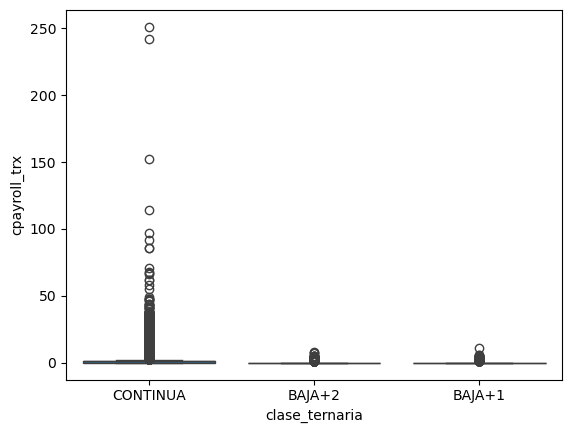

In [21]:
# Grafico.
sns.boxplot(x='clase_ternaria', y='cpayroll_trx', data=data)

<Axes: xlabel='clase_ternaria', ylabel='cpayroll_trx'>

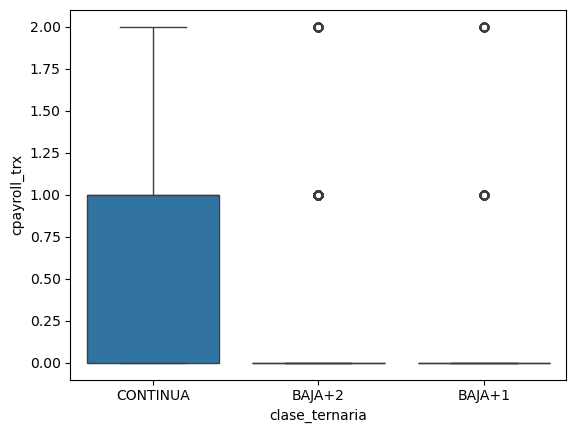

In [22]:
# Grafico.
lower_bound = data['cpayroll_trx'].quantile(0.10)
upper_bound = data['cpayroll_trx'].quantile(0.90)
filtered_data = data[(data['cpayroll_trx'] >= lower_bound) & (data['cpayroll_trx'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='cpayroll_trx', data=filtered_data)

In [ ]:
print('''
      a
      ''')